In [1]:
import numpy as np
import pandas as pd
import glob

In [2]:
FOLDER = 'train'
FOLDER_TRAIN = 'train'
FOLDER_TEST = 'test'

TRAIN = FOLDER_TRAIN + '/train_labels.csv'

In [3]:
train_data = pd.read_csv(TRAIN,sep=';',header=0, names=['date', 'is_rain'] )
train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')

In [4]:
train_data.groupby(['is_rain']).count()

""
is_rain
0
1


In [5]:
features = [f.replace('train/2019_06/','').replace('_2019_06.csv','') for f in glob.glob(FOLDER_TRAIN+'/2019_06/*.csv')]

In [6]:
features

['B00702A',
 'B00300S',
 'B00305A',
 'B00202A',
 'B00703A',
 'B00604S',
 'B00606S',
 'B00608S',
 'B00802A',
 'B00714A']

In [7]:
stacje = pd.read_csv(FOLDER+'/ats.txt',sep='\s+', header=0,names=['stacja_numer','lat','lng'])
stacje['stacja_numer'] = stacje['stacja_numer'].astype(str)

stacje.head()

,stacja_numer,lat,lng
0,249220350,49.12194,22.58556
1,249220330,49.12472,22.79139
2,249220310,49.14472,22.47167
3,249220290,49.15361,22.31722
4,249220320,49.15778,22.55167


In [8]:
all_columns =  [stacja + '_' + feature for stacja in stacje['stacja_numer'] for feature in features]
#all_types = [pd.datetime] + [float for i in all_columns]

all_columns = ["date_"] + all_columns

In [9]:
# DANE Z MIESIECY
import glob

train_files = glob.glob('train/**/*.csv')
test_files = glob.glob('test/**/*.csv')

In [10]:
# full_dataframe = pd.DataFrame(columns = all_columns)

In [11]:
import glob
import os.path
import pandas as pd

def parse_core_to_pandas(path):
    """Weather Core Dataset parser.

    Args:
        path (string): Path to a directory containing .csv files.

    Returns:
        pandas.DataFrame with MultiIndex([station_id, timestamp]) and parameter
        indices as columns.
    """

    dfs = []
    for file_path in glob.glob(os.path.join(path, 'B*.csv')):
        df = pd.read_csv(file_path,
                         delimiter=';',
                         decimal=",",
                         usecols=range(4),
                         names=['station_id', 'param_id', 'timestamp', 'value'],
                         dtype={'station_id': str,
                                'param_id': str,
                                'timestamp': str,
                                'value': float})
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.pivot_table(index=['station_id', 'timestamp'],
                        columns='param_id',
                        values='value')
    return df

In [12]:
def convert_to_columns(df):
    return df.pivot_table(index='timestamp',columns=['station_id'],values=features)

In [14]:
dict_names = {
    'B00300S' : 'Air-temperature',
    'B00305A' :	'Soil-temperature',
    'B00202A' : 'Wind-direction',
    'B00702A' : 'Avg-wind-speed-past-10-mts',
    'B00703A' : 'Max-speed',
    'B00608S' : 'Precipitation-sum-past-10-mts',
    'B00604S' : 'Precipitation-sum-past-24-hrs',
    'B00606S' : 'Precipitation-sum-past-1-hrs',
    'B00802A' : 'Relative-humidity',
    'B00714A' : 'Max-wind-past-10-mts',
    'B00910A' : 'Water-in-snow'
}

def fix_column_names(df, d):
    rename_d = {}
    for column in df.columns:
        column_list = column.split("_")
        station_name = column_list[1]
        coded_name = column_list[0]
        suffix = coded_name
        if coded_name in d:
            suffix = d[coded_name]
        rename_d[coded_name+'_'+station_name] = station_name+"_"+suffix
    #df.rename(columns=rename_d,inplace=True)
    return df

def prepare_data(data):
    y=None
    if 'is_rain' in data:
        y = data['is_rain']
        X = data.drop(columns=['is_rain'])
    else:
        X = data
    print(X.isnull().values.any())
    X.fillna(method='ffill', inplace=True)
    X.fillna(method='bfill', inplace=True)
    print(X.isnull().values.any())
    X = fix_column_names(X, dict_names)
    return X, y

In [15]:
# station_id = [
#     '253200080',
#     '353200272',
#     '351220495',
#     '249200110',
#     '254200080'
#     '249210240'
# # '250160150',
# # '250150110',
# # '354150100',
# # '351230497',
# # '253210210',
# # '253200080',
# # '250210070',
# # '250160450',
# # '250160190',
# # '249220310',
# # '353200272',
# # '351220495',
# # '249200110',
# # '250220030'
# ]

station_id = [
    '253200080',
    '353200272'
]

def hpa2ft(hpa):
    return (1 - (hpa / 1013.25) ** 0.190_284) * 145_366.45

def prepare_all_data(folder, all_columns=False):
    all_data = parse_core_to_pandas(folder+'/**/')
    if all_columns == False:
        all_data = all_data.loc[station_id]
    full_data = convert_to_columns(all_data)
    full_data.columns = full_data.columns.map('_'.join)
    #full_data = full_data.set_index('date')
    
    return full_data

def prepare_train(folder, all_columns=False):
    full_data = prepare_all_data(folder,all_columns=all_columns)
    train_all = train_data.merge(full_data, left_index=True,right_index=True)
    return train_all
    
def save_data(df,file):
    import pickle
    pickle.dump(df, open( file, "wb" ))

# ALL DATA ONLY EXTRACCTION

In [1009]:
all_train_columns = prepare_train(FOLDER_TRAIN, all_columns=True)

In [1010]:
all_train_columns

,is_rain,B00202A_249180010,B00202A_249180130,B00202A_249180160,B00202A_249180210,B00202A_249180230,B00202A_249180260,B00202A_249190030,B00202A_249190090,B00202A_249190130,...,B00802A_354150100,B00802A_354160105,B00802A_354160115,B00802A_354170120,B00802A_354170125,B00802A_354180135,B00802A_354180155,B00802A_354190160,B00802A_354210185,B00802A_354220195
2019-06-01 01:00:00,0,190.0,0.0,122.0,249.0,156.0,315.4,230.4,207.0,243.0,...,99.0,95.0,96.0,100.0,97.0,96.0,95.0,97.0,94.0,87.0
2019-06-01 02:00:00,0,201.0,41.5,123.0,300.0,134.0,0.0,224.7,195.0,233.0,...,99.0,96.0,98.0,100.0,98.0,97.0,95.0,97.0,95.0,86.0
2019-06-01 03:00:00,0,208.0,50.9,124.0,342.0,107.0,357.2,0.0,172.0,222.0,...,99.0,96.0,98.0,100.0,99.0,97.0,96.0,97.0,95.0,88.0
2019-06-01 04:00:00,0,194.0,0.0,119.0,10.0,57.0,320.4,242.0,210.0,308.0,...,99.0,96.0,98.0,100.0,99.0,97.0,96.0,95.0,94.0,86.0
2019-06-01 05:00:00,0,216.0,0.0,98.0,93.0,64.0,0.0,252.1,250.0,167.0,...,98.0,95.0,96.0,100.0,99.0,95.0,92.0,91.0,91.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 19:00:00,0,43.0,130.1,116.0,342.0,115.0,150.6,116.7,56.0,223.0,...,60.0,55.0,56.0,76.0,67.0,83.0,73.0,74.0,74.0,81.0
2019-08-31 20:00:00,0,121.0,120.8,125.0,308.0,157.0,156.2,0.0,75.0,238.0,...,62.0,59.0,57.0,72.0,71.0,87.0,79.0,76.0,77.0,86.0
2019-08-31 21:00:00,0,92.0,93.3,127.0,83.0,148.0,146.0,76.4,113.0,249.0,...,63.0,62.0,60.0,73.0,75.0,89.0,80.0,79.0,81.0,90.0
2019-08-31 22:00:00,0,121.0,104.4,125.0,179.0,158.0,138.0,88.5,76.0,231.0,...,66.0,64.0,58.0,74.0,72.0,90.0,79.0,78.0,81.0,92.0


In [951]:
all_columns_train_X, all_columns_train_Y = prepare_data(all_train_columns)

True
False


In [952]:
save_data(all_columns_train_X, "allstations_train_x.pkl")
save_data(all_columns_train_Y, "allstations_train_y.pkl")

In [953]:
pickle.load(open( "allstations_train_y.pkl",'rb'))

2019-06-01 01:00:00    0
2019-06-01 02:00:00    0
2019-06-01 03:00:00    0
2019-06-01 04:00:00    0
2019-06-01 05:00:00    0
                      ..
2019-08-31 19:00:00    0
2019-08-31 20:00:00    0
2019-08-31 21:00:00    0
2019-08-31 22:00:00    0
2019-08-31 23:00:00    0
Name: is_rain, Length: 1703, dtype: int64

In [954]:
all_test_columns = prepare_all_data(FOLDER_TEST, all_columns=True)

In [955]:
all_test_columns = all_test_columns[all_test_columns.index.str[-2:]=='00']

In [956]:
all_test_columns_X, _ = prepare_data(all_test_columns)

True
False


In [957]:
save_data(all_test_columns_X, "allstations_test_x.pkl")


In [958]:
pickle.load(open("allstations_test_x.pkl",'rb'))

,249180010_Wind-direction,249180130_Wind-direction,249180160_Wind-direction,249180210_Wind-direction,249180230_Wind-direction,249180260_Wind-direction,249190030_Wind-direction,249190090_Wind-direction,249190130_Wind-direction,249190140_Wind-direction,...,354150100_Relative-humidity,354160105_Relative-humidity,354160115_Relative-humidity,354170120_Relative-humidity,354170125_Relative-humidity,354180135_Relative-humidity,354180155_Relative-humidity,354190160_Relative-humidity,354210185_Relative-humidity,354220195_Relative-humidity
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-07 00:00,114.0,17.8,133.0,350.0,113.0,155.3,184.5,113.0,224.0,125.0,...,97.0,94.0,83.0,82.0,75.0,93.0,89.0,91.0,88.0,93.0
2019-06-07 01:00,166.0,0.0,116.0,12.0,166.0,151.0,0.0,220.0,239.0,120.0,...,98.0,94.0,89.0,91.0,85.0,93.0,92.0,91.0,90.0,92.0
2019-06-07 02:00,288.0,45.5,112.0,341.0,181.0,170.4,258.1,223.0,237.0,136.0,...,97.0,95.0,94.0,90.0,90.0,93.0,94.0,87.0,91.0,91.0
2019-06-07 03:00,155.0,243.6,113.0,220.0,165.0,177.7,232.3,243.0,235.0,142.0,...,98.0,97.0,95.0,95.0,91.0,92.0,94.0,88.0,93.0,92.0
2019-06-07 04:00,242.0,251.1,249.0,236.0,214.0,193.6,60.6,242.0,185.0,164.0,...,99.0,96.0,96.0,96.0,93.0,90.0,92.0,84.0,85.0,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-19 19:00,93.0,0.0,108.0,253.0,161.0,348.5,295.2,240.0,233.0,294.0,...,84.0,79.0,81.0,84.0,80.0,91.0,75.0,78.0,93.0,89.0
2019-08-19 20:00,212.0,44.2,127.0,303.0,101.0,328.6,250.6,236.0,214.0,298.0,...,81.0,88.0,81.0,92.0,84.0,95.0,83.0,85.0,93.0,92.0
2019-08-19 21:00,211.0,20.1,131.0,325.0,111.0,347.4,242.4,248.0,246.0,306.0,...,79.0,88.0,82.0,97.0,88.0,94.0,93.0,89.0,95.0,93.0


## SELECTED FEATURES FROM EXTRACTION

In [ ]:
all_train = prepare_train(FOLDER_TRAIN, all_columns=False)

In [1096]:
all_train.columns

Index(['is_rain', 'B00202A_353200272', 'B00300S_353200272',
       'B00305A_353200272', 'B00604S_253200080', 'B00604S_353200272',
       'B00606S_253200080', 'B00606S_353200272', 'B00608S_253200080',
       'B00608S_353200272', 'B00702A_353200272', 'B00703A_353200272',
       'B00714A_353200272', 'B00802A_353200272'],
      dtype='object')

In [1120]:
prepare_data(all_train)

True
False


(                     B00202A_353200272  B00300S_353200272  B00305A_353200272  \
 2019-06-01 01:00:00              333.0               12.0               11.5   
 2019-06-01 02:00:00              305.0               12.6               12.4   
 2019-06-01 03:00:00                0.0               12.6               11.4   
 2019-06-01 04:00:00              211.0               12.3               12.9   
 2019-06-01 05:00:00              179.0               13.2               14.8   
 ...                                ...                ...                ...   
 2019-08-31 19:00:00               94.0               21.8               20.0   
 2019-08-31 20:00:00              113.0               20.7               18.2   
 2019-08-31 21:00:00              107.0               19.4               15.6   
 2019-08-31 22:00:00              124.0               18.9               15.1   
 2019-08-31 23:00:00              120.0               18.1               14.0   
 
                      B006

In [1127]:
train_X, train_Y = prepare_data(all_train)

True
False


In [1137]:
train_X.isnull().values.any()

False

In [1143]:
train_X

,B00202A_353200272,B00300S_353200272,B00305A_353200272,B00604S_253200080,B00604S_353200272,B00606S_253200080,B00606S_353200272,B00608S_253200080,B00608S_353200272,B00702A_353200272,B00703A_353200272,B00714A_353200272,B00802A_353200272
2019-06-01 01:00:00,333.0,12.0,11.5,0.8,0.3,0.0,0.0,0.0,0.0,0.9,1.4,10.0,96.0
2019-06-01 02:00:00,305.0,12.6,12.4,0.8,0.3,0.0,0.0,0.0,0.0,1.4,1.8,10.0,96.0
2019-06-01 03:00:00,0.0,12.6,11.4,0.8,0.3,0.0,0.0,0.0,0.0,0.0,0.0,10.0,94.0
2019-06-01 04:00:00,211.0,12.3,12.9,0.8,0.3,0.0,0.0,0.0,0.0,0.6,1.2,10.0,96.0
2019-06-01 05:00:00,179.0,13.2,14.8,0.8,0.3,0.0,0.0,0.0,0.0,0.5,1.2,10.0,93.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 19:00:00,94.0,21.8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,4.3,11.0,68.0
2019-08-31 20:00:00,113.0,20.7,18.2,0.0,0.0,0.0,0.0,0.0,0.0,2.7,3.8,11.0,70.0
2019-08-31 21:00:00,107.0,19.4,15.6,0.0,0.0,0.0,0.0,0.0,0.0,2.2,3.4,11.0,74.0
2019-08-31 22:00:00,124.0,18.9,15.1,0.0,0.0,0.0,0.0,0.0,0.0,1.5,2.3,11.0,76.0


In [1151]:
save_data(train_X, "train_2C_x.pkl")
save_data(train_Y, "train_2C_y.pkl")
c = pickle.load(open('train_2C_x.pkl','rb'))


False

### TEST

In [1017]:
all_test = prepare_all_data(FOLDER_TEST, all_columns=False)

In [1018]:
test_x, test_y = prepare_data(all_test)

True
False


In [1019]:
test_x = test_x[test_x.index.str[-2:]=='00']

In [1020]:
save_data(test_x,'test_2C_x.pkl')
pickle.load(open('test_2C_x.pkl','rb'))

,353200272_Wind-direction,353200272_Air-temperature,353200272_Soil-temperature,253200080_Precipitation-sum-past-24-hrs,353200272_Precipitation-sum-past-24-hrs,253200080_Precipitation-sum-past-1-hrs,353200272_Precipitation-sum-past-1-hrs,253200080_Precipitation-sum-past-10-mts,353200272_Precipitation-sum-past-10-mts,353200272_Avg-wind-speed-past-10-mts,353200272_Max-speed,353200272_Max-wind-past-10-mts,353200272_Relative-humidity
timestamp,,,,,,,,,,,,,
2019-06-07 00:00,133.0,19.6,17.6,1.4,0.3,0.0,0.0,0.0,0.0,2.0,4.0,7.0,82.0
2019-06-07 01:00,138.0,19.2,17.9,1.4,0.3,0.0,0.0,0.0,0.0,1.8,3.2,7.0,80.0
2019-06-07 02:00,104.0,18.2,16.4,1.4,0.3,0.0,0.0,0.0,0.0,2.2,3.6,7.0,84.0
2019-06-07 03:00,123.0,17.9,17.2,1.4,0.3,0.0,0.0,0.0,0.0,2.5,3.7,7.0,82.0
2019-06-07 04:00,129.0,18.2,18.5,1.4,0.3,0.0,0.0,0.0,0.0,2.9,4.8,7.0,81.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-19 19:00,246.0,19.6,18.6,0.0,0.0,0.0,0.0,0.0,0.0,1.5,3.0,8.0,78.0
2019-08-19 20:00,238.0,18.9,17.6,0.0,0.0,0.0,0.0,0.0,0.0,1.3,2.0,8.0,80.0
2019-08-19 21:00,248.0,18.6,18.1,0.0,0.0,0.0,0.0,0.0,0.0,1.3,2.4,8.0,77.0


# GRS

In [1021]:
grs_data = pickle.load(open('rain/grs.pkl','rb'))
#grs_data['date'] = grs_data['date'].astype(str)

In [1022]:
train_X = train_X.merge(grs_data,how='left', left_index=True,right_on='date')

In [1023]:
train_X = train_X.set_index('date').fillna(method='ffill')

In [1024]:
train_X

,353200272_Wind-direction,353200272_Air-temperature,353200272_Soil-temperature,253200080_Precipitation-sum-past-24-hrs,353200272_Precipitation-sum-past-24-hrs,253200080_Precipitation-sum-past-1-hrs,353200272_Precipitation-sum-past-1-hrs,253200080_Precipitation-sum-past-10-mts,353200272_Precipitation-sum-past-10-mts,353200272_Avg-wind-speed-past-10-mts,353200272_Max-speed,353200272_Max-wind-past-10-mts,353200272_Relative-humidity,value
date,,,,,,,,,,,,,,
2019-06-01 01:00:00,333.0,12.0,11.5,0.8,0.3,0.0,0.0,0.0,0.0,0.9,1.4,10.0,96.0,0.0
2019-06-01 02:00:00,305.0,12.6,12.4,0.8,0.3,0.0,0.0,0.0,0.0,1.4,1.8,10.0,96.0,0.0
2019-06-01 03:00:00,0.0,12.6,11.4,0.8,0.3,0.0,0.0,0.0,0.0,0.0,0.0,10.0,94.0,0.0
2019-06-01 04:00:00,211.0,12.3,12.9,0.8,0.3,0.0,0.0,0.0,0.0,0.6,1.2,10.0,96.0,0.0
2019-06-01 05:00:00,179.0,13.2,14.8,0.8,0.3,0.0,0.0,0.0,0.0,0.5,1.2,10.0,93.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 19:00:00,94.0,21.8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,4.3,11.0,68.0,0.0
2019-08-31 20:00:00,113.0,20.7,18.2,0.0,0.0,0.0,0.0,0.0,0.0,2.7,3.8,11.0,70.0,0.0
2019-08-31 21:00:00,107.0,19.4,15.6,0.0,0.0,0.0,0.0,0.0,0.0,2.2,3.4,11.0,74.0,0.0


In [1025]:
test_x.index = pd.to_datetime(test_x.index)

In [1026]:
test_x = test_x.merge(grs_data,how='left', left_index=True,right_on='date')

In [1027]:
test_x.set_index('date',inplace=True)

In [1028]:
save_data(train_X,'train_2C_gprs_x.pkl')
save_data(test_x,'test_2C_gprs_x.pkl')
pickle.load(open('train_2C_gprs_x.pkl','rb'))

,353200272_Wind-direction,353200272_Air-temperature,353200272_Soil-temperature,253200080_Precipitation-sum-past-24-hrs,353200272_Precipitation-sum-past-24-hrs,253200080_Precipitation-sum-past-1-hrs,353200272_Precipitation-sum-past-1-hrs,253200080_Precipitation-sum-past-10-mts,353200272_Precipitation-sum-past-10-mts,353200272_Avg-wind-speed-past-10-mts,353200272_Max-speed,353200272_Max-wind-past-10-mts,353200272_Relative-humidity,value
date,,,,,,,,,,,,,,
2019-06-01 01:00:00,333.0,12.0,11.5,0.8,0.3,0.0,0.0,0.0,0.0,0.9,1.4,10.0,96.0,0.0
2019-06-01 02:00:00,305.0,12.6,12.4,0.8,0.3,0.0,0.0,0.0,0.0,1.4,1.8,10.0,96.0,0.0
2019-06-01 03:00:00,0.0,12.6,11.4,0.8,0.3,0.0,0.0,0.0,0.0,0.0,0.0,10.0,94.0,0.0
2019-06-01 04:00:00,211.0,12.3,12.9,0.8,0.3,0.0,0.0,0.0,0.0,0.6,1.2,10.0,96.0,0.0
2019-06-01 05:00:00,179.0,13.2,14.8,0.8,0.3,0.0,0.0,0.0,0.0,0.5,1.2,10.0,93.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 19:00:00,94.0,21.8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2.6,4.3,11.0,68.0,0.0
2019-08-31 20:00:00,113.0,20.7,18.2,0.0,0.0,0.0,0.0,0.0,0.0,2.7,3.8,11.0,70.0,0.0
2019-08-31 21:00:00,107.0,19.4,15.6,0.0,0.0,0.0,0.0,0.0,0.0,2.2,3.4,11.0,74.0,0.0


In [1029]:
pickle.load(open('test_2C_gprs_x.pkl','rb'))

,353200272_Wind-direction,353200272_Air-temperature,353200272_Soil-temperature,253200080_Precipitation-sum-past-24-hrs,353200272_Precipitation-sum-past-24-hrs,253200080_Precipitation-sum-past-1-hrs,353200272_Precipitation-sum-past-1-hrs,253200080_Precipitation-sum-past-10-mts,353200272_Precipitation-sum-past-10-mts,353200272_Avg-wind-speed-past-10-mts,353200272_Max-speed,353200272_Max-wind-past-10-mts,353200272_Relative-humidity,value
date,,,,,,,,,,,,,,
2019-06-07 00:00:00,133.0,19.6,17.6,1.4,0.3,0.0,0.0,0.0,0.0,2.0,4.0,7.0,82.0,0.0
2019-06-07 01:00:00,138.0,19.2,17.9,1.4,0.3,0.0,0.0,0.0,0.0,1.8,3.2,7.0,80.0,0.0
2019-06-07 02:00:00,104.0,18.2,16.4,1.4,0.3,0.0,0.0,0.0,0.0,2.2,3.6,7.0,84.0,0.0
2019-06-07 03:00:00,123.0,17.9,17.2,1.4,0.3,0.0,0.0,0.0,0.0,2.5,3.7,7.0,82.0,0.0
2019-06-07 04:00:00,129.0,18.2,18.5,1.4,0.3,0.0,0.0,0.0,0.0,2.9,4.8,7.0,81.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-19 19:00:00,246.0,19.6,18.6,0.0,0.0,0.0,0.0,0.0,0.0,1.5,3.0,8.0,78.0,0.0
2019-08-19 20:00:00,238.0,18.9,17.6,0.0,0.0,0.0,0.0,0.0,0.0,1.3,2.0,8.0,80.0,0.0
2019-08-19 21:00:00,248.0,18.6,18.1,0.0,0.0,0.0,0.0,0.0,0.0,1.3,2.4,8.0,77.0,0.0


## MERGE WITH SIMILATION.pkl

In [1030]:
simulation = pickle.load(open('simulation.pkl','rb'))
simulation['date'] = simulation['date'].astype(str)
simulation = simulation.pivot_table(index='date',columns='feature',values='value')
simulation

feature,00_000_0,00_000_1,00_000_10,00_000_11,00_000_12,00_000_13,00_000_14,00_000_15,00_000_16,00_000_17,...,00_030_45,00_030_46,00_030_47,00_030_48,00_030_49,00_030_5,00_030_6,00_030_7,00_030_8,00_030_9
date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,284.767101,177.624232,1.091319,0.000000,18.759394,0.001745,2.078629,-1.862498,7.379684,8.638657,...,78.460306,27.726160,16.081199,72.925073,67.218757,0.0,2.088953,-0.606113,293.488279,69.573879
2019-06-02,286.661577,177.624232,4.922587,0.000000,8.368897,0.000000,0.691684,-0.114595,7.017974,10.033183,...,47.544748,78.468044,27.977449,43.668240,45.177203,0.0,-1.040954,1.631489,291.079559,47.536719
2019-06-03,284.499533,177.624232,0.001520,11.862475,0.000000,0.000000,-1.697764,1.644962,6.989633,5.374100,...,44.894469,46.050066,14.562198,41.583854,40.122920,0.0,-1.025799,1.670566,294.190115,47.586721
2019-06-04,287.696159,177.624232,0.001526,0.000000,0.000000,0.001984,-1.336902,2.785656,4.510644,-0.128311,...,53.472406,9.376010,59.450328,60.695076,45.996636,0.0,-1.338285,1.453547,296.185154,57.508510
2019-06-05,290.443144,177.624232,0.001520,0.000000,0.000000,0.001495,-1.071116,2.412904,0.341166,-0.981388,...,76.431782,13.313433,54.478806,66.444665,69.539028,0.0,-2.699839,2.248312,296.119013,60.560018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,289.783131,177.624232,0.001526,0.000000,0.000000,0.000000,-6.550749,2.975277,0.807522,-10.302343,...,19.077796,16.265768,42.533562,58.010387,43.228829,0.0,-2.090181,1.474621,295.641068,42.874479
2019-08-28,292.292536,177.624232,0.001526,25.689316,0.000942,0.000000,-9.893896,7.639531,3.355525,-3.979862,...,79.459697,77.941689,85.932532,80.426073,68.819177,0.0,-1.235965,1.999425,295.849146,64.589500
2019-08-29,291.053484,177.624232,13.549423,52.192557,0.000000,14.387878,-6.060987,6.648405,5.939715,10.085951,...,68.387783,10.852157,55.257457,68.083113,65.529954,0.0,0.894382,-1.388917,294.101614,80.067402


In [1031]:
train_X.index.rename('timestamp',inplace=True)

In [1032]:
train_X['date'] = train_X.index.astype(str).str[:len('2019-06-01')]

In [1033]:
train_X = train_X.merge(simulation,left_on='date',right_index=True)

In [1034]:
train_X.drop(columns=['date'],inplace=True)

In [1035]:
save_data(simulation_train_X, "train_2C_simulation_x.pkl")
pickle.load(open('train_2C_simulation_x.pkl','rb'))

,value,353200272_Wind-direction,353200272_Air-temperature,353200272_Soil-temperature,253200080_Precipitation-sum-past-24-hrs,353200272_Precipitation-sum-past-24-hrs,253200080_Precipitation-sum-past-1-hrs,353200272_Precipitation-sum-past-1-hrs,253200080_Precipitation-sum-past-10-mts,353200272_Precipitation-sum-past-10-mts,...,00_030_45,00_030_46,00_030_47,00_030_48,00_030_49,00_030_5,00_030_6,00_030_7,00_030_8,00_030_9
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-14 23:00:00,0.0,17.0,16.6,14.6,50.5,29.2,0.0,0.0,0.0,0.0,...,68.105879,69.114318,48.404422,21.256894,44.624072,0.0,-1.857630,-1.425723,291.835394,75.346619
2019-06-14 16:00:00,0.0,324.0,23.5,25.3,50.5,29.2,0.0,0.0,0.0,0.0,...,68.105879,69.114318,48.404422,21.256894,44.624072,0.0,-1.857630,-1.425723,291.835394,75.346619
2019-06-14 08:00:00,0.0,278.0,20.1,20.2,50.5,29.2,0.0,0.0,0.0,0.0,...,68.105879,69.114318,48.404422,21.256894,44.624072,0.0,-1.857630,-1.425723,291.835394,75.346619
2019-06-14 13:00:00,0.0,36.0,23.5,26.5,50.5,29.2,0.0,0.0,0.0,0.0,...,68.105879,69.114318,48.404422,21.256894,44.624072,0.0,-1.857630,-1.425723,291.835394,75.346619
2019-06-14 22:00:00,0.0,17.0,17.2,15.9,50.5,29.2,0.0,0.0,0.0,0.0,...,68.105879,69.114318,48.404422,21.256894,44.624072,0.0,-1.857630,-1.425723,291.835394,75.346619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31 19:00:00,0.0,94.0,21.8,20.0,0.0,0.0,0.0,0.0,0.0,0.0,...,66.452640,17.583345,29.637685,61.199230,53.636062,0.0,-1.450052,1.930974,294.877052,53.423589
2019-08-31 20:00:00,0.0,113.0,20.7,18.2,0.0,0.0,0.0,0.0,0.0,0.0,...,66.452640,17.583345,29.637685,61.199230,53.636062,0.0,-1.450052,1.930974,294.877052,53.423589
2019-08-31 21:00:00,0.0,107.0,19.4,15.6,0.0,0.0,0.0,0.0,0.0,0.0,...,66.452640,17.583345,29.637685,61.199230,53.636062,0.0,-1.450052,1.930974,294.877052,53.423589


(array([1.678e+03, 1.200e+01, 3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 array([ 0.   ,  1.356,  2.712,  4.068,  5.424,  6.78 ,  8.136,  9.492,
        10.848, 12.204, 13.56 ]),
 <a list of 10 Patch objects>)

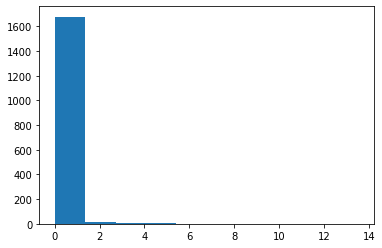

In [1036]:
from matplotlib import pyplot as plt
plt.hist(pickle.load(open('train_2C_simulation_x.pkl','rb'))['value'])

# TEST SIMULATION

In [1037]:
test_x['date'] = test_x.index.astype(str).str[:len('2019-06-01')]

In [1038]:
test_x.index.rename('timestamp',inplace=True)

In [1039]:
test_x = test_x.merge(simulation,left_on='date',right_index=True)

In [1040]:
test_x.drop(columns=['date'],inplace=True)

In [1041]:
save_data(test_x,"test_2C_simulation_x.pkl")
pickle.load(open('test_2C_simulation_x.pkl','rb'))

,353200272_Wind-direction,353200272_Air-temperature,353200272_Soil-temperature,253200080_Precipitation-sum-past-24-hrs,353200272_Precipitation-sum-past-24-hrs,253200080_Precipitation-sum-past-1-hrs,353200272_Precipitation-sum-past-1-hrs,253200080_Precipitation-sum-past-10-mts,353200272_Precipitation-sum-past-10-mts,353200272_Avg-wind-speed-past-10-mts,...,00_030_45,00_030_46,00_030_47,00_030_48,00_030_49,00_030_5,00_030_6,00_030_7,00_030_8,00_030_9
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-06-07 00:00:00,133.0,19.6,17.6,1.4,0.3,0.0,0.0,0.0,0.0,2.0,...,52.375031,6.119898,46.450770,64.884204,63.161951,0.0,-1.041270,1.794884,296.593073,63.994259
2019-06-07 01:00:00,138.0,19.2,17.9,1.4,0.3,0.0,0.0,0.0,0.0,1.8,...,52.375031,6.119898,46.450770,64.884204,63.161951,0.0,-1.041270,1.794884,296.593073,63.994259
2019-06-07 02:00:00,104.0,18.2,16.4,1.4,0.3,0.0,0.0,0.0,0.0,2.2,...,52.375031,6.119898,46.450770,64.884204,63.161951,0.0,-1.041270,1.794884,296.593073,63.994259
2019-06-07 03:00:00,123.0,17.9,17.2,1.4,0.3,0.0,0.0,0.0,0.0,2.5,...,52.375031,6.119898,46.450770,64.884204,63.161951,0.0,-1.041270,1.794884,296.593073,63.994259
2019-06-07 04:00:00,129.0,18.2,18.5,1.4,0.3,0.0,0.0,0.0,0.0,2.9,...,52.375031,6.119898,46.450770,64.884204,63.161951,0.0,-1.041270,1.794884,296.593073,63.994259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-19 19:00:00,246.0,19.6,18.6,0.0,0.0,0.0,0.0,0.0,0.0,1.5,...,17.552692,57.868107,6.270001,40.403175,50.156856,0.0,1.151194,0.550652,291.552019,69.631130
2019-08-19 20:00:00,238.0,18.9,17.6,0.0,0.0,0.0,0.0,0.0,0.0,1.3,...,17.552692,57.868107,6.270001,40.403175,50.156856,0.0,1.151194,0.550652,291.552019,69.631130
2019-08-19 21:00:00,248.0,18.6,18.1,0.0,0.0,0.0,0.0,0.0,0.0,1.3,...,17.552692,57.868107,6.270001,40.403175,50.156856,0.0,1.151194,0.550652,291.552019,69.631130
